## 1. Data postprocessing

Load libraries needed.

In [21]:
import os
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
sns.set_context("talk")

Define the labels we want to use for the synonyms, and sort them in alphabetical order.

In [9]:
synonyms = [("aeroplane", "airplane", "a(e|i)r(o)plane"),
            ("aluminium", "aluminum", r"alumin(i)um"),
            ("doughnut", "donut", r"do(ugh)nut"),
            ("foetus", "fetus", r"f(o)etus"),
            ("flautist", "flutist", r"fl(a)utist"),
            ("moustache", "mustache", r"m(o)ustache"),
            ("tumour", "tumor", r"tumo(u)r"),
            ("pyjamas", "pajamas", "p(y|a)jamas"),
            ("sulphate", "sulfate", "sul(ph|f)ate"),
            ("yoghurt", "yogurt", "yog(h)urt"),
            ("aubergine", "eggplant", "aubergine /\neggplant"),
            ("shopping trolley", "shopping cart", "shopping trolley /\nshopping cart"),
            ("veterinary surgeon", "veterinarian", "veterinarian /\nveterinary surgeon"),
            ("sailing boat", "sailboat", "sail(ing )boat"),
            ("football", "soccer", "football / soccer"),
            ("holiday", "vacation", "holiday / vacation"),
            ("ladybird", "ladybug", "ladybird / ladybug"),
            ("theatre", "theater", "theat(re|er)"),
            ("postcode", "zip code", "postcode / zip code"),
            ("whisky", "whiskey", "whisk(e)y")]

indices = sorted(range(len(synonyms)), key=lambda k: synonyms[k])
first_half = list(reversed(indices[:10]))
second_half = list(reversed(indices[10:]))

Now process the data stored by `evaluate.py` in `results.pickle`, that gives consistencies and noun consistencies per model type, seed, data type, template and synonym.

In [4]:
all_annotations = []
models, data_types, consistency = [], [], []
per_synonym = defaultdict(list)
per_synonym_noun = defaultdict(list)

results = pickle.load(open("results.pickle", 'rb'))
for data_type in ["synthetic", "semi_natural", "natural"]:
    for model in ["tiny", "small", "all"]:
        annotations = []
        for syn_num in range(20):
            if data_type != "natural":
                cons, cons_noun_only = zip(*[results[(model, seed, data_type, t, syn_num)]
                                             for t in range(1, 11) for seed in [1, 2, 3, 4, 5]])
            else:
                cons, cons_noun_only = zip(*[results[(model, seed, data_type, syn_num)]
                                             for t in range(1, 11) for seed in [1, 2, 3, 4, 5]])
            models.append(model)
            data_types.append(data_type)
            consistency.append(np.mean(cons))
            annotations.append((data_type, model, np.mean(cons), synonyms[syn_num][0]))
            per_synonym[syn_num].append(np.mean(cons))
            per_synonym_noun[syn_num].append(np.mean(cons_noun_only))

        all_annotations.extend([min(annotations), max(annotations)])

## 2. Visualise consistency across synonyms, data types, training set sizes

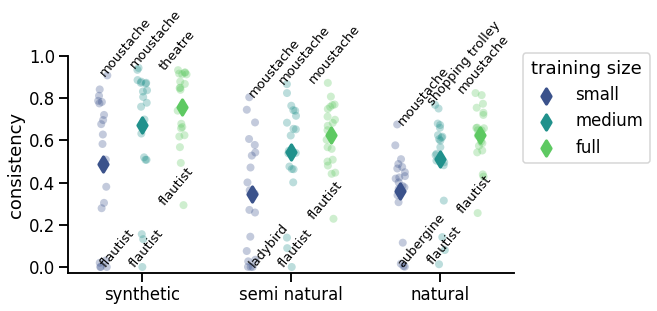

In [7]:
plt.figure(figsize=(8, 4))
ax = sns.pointplot(x=data_types, y=consistency, hue=models,
                   dodge=.532, join=False, 
                   markers="d", scale=1.05, ci=None, palette="viridis")

sns.stripplot(x=data_types, y=consistency, hue=models,
              dodge=True, zorder=-1, label=None, alpha=0.3, size=8, palette="viridis",
              marker='o')
plt.legend(["small", "medium", "full"], title="training size", bbox_to_anchor=(1, 1.05))
sns.despine(top=True, right=True)
ax.set_xticklabels(["synthetic", "semi natural", "natural"])
ax.set_ylabel("consistency")
plt.ylim(-0.03, 1)

for x, m, y, t in all_annotations:
    x = {"synthetic": 0, "semi_natural": 1, "natural": 2}[x]
    if m == "tiny":
        x -= 0.3
    if m == "small":
        x -=0.1
    if m == "all":
        x += 0.1
    plt.text(x, y, t, fontsize=13, rotation=50)
plt.savefig("figures/consistency.pdf", bbox_inches="tight")
plt.show()

## 3. Visualise performance per synonym

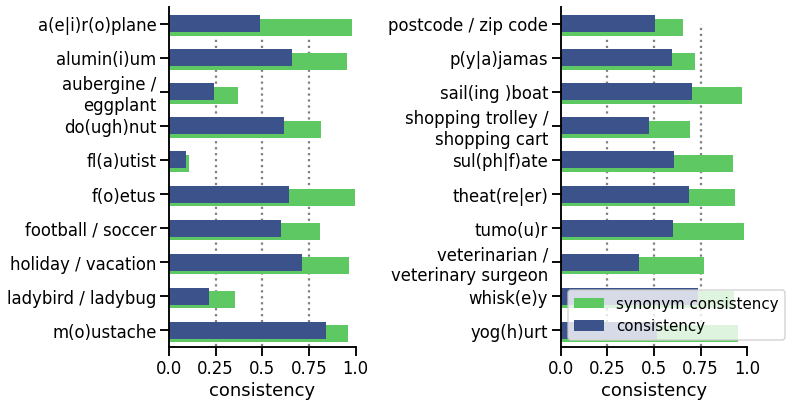

In [8]:
colours = sns.color_palette("viridis", 3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

for i, (size, half, ax) in enumerate([(3.3, first_half, ax1), (3.5, second_half, ax2)]):
    
    x, y, y2, syns = [], [], [], []
    for j, s in enumerate(half):
        y.append(np.mean(per_synonym_noun[s]))
        y2.append(np.mean(per_synonym[s]))
        x.append(j)
        syns.append(s)

    ax.barh([z - 0.1 for z in x], [z for z in y], 0.5, color=colours[2], label="synonym consistency")
    ax.barh(x, [z for z in y2], 0.5, color=colours[0], label="consistency")

    ax.set_ylim(-0.5, 9.5)
    ax.set_xlim(0, 1.0)
    ax.set_yticks(x)
    ax.set_yticklabels([f"{synonyms[x][2]}" for x in syns])
    ax.set_xlabel("consistency")
    sns.despine(top=True, right=True)
    ax.plot([0.25, 0.25], [-1, 9], zorder=-1, linestyle='dotted', color="grey")
    ax.plot([0.5, 0.5], [-1, 9], zorder=-1, linestyle='dotted', color="grey")
    ax.plot([0.75, 0.75], [-1, 9], zorder=-1, linestyle='dotted', color="grey")
    ax.set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0.0, 0.25, 0.5, 0.75, 1.0])

    if i == 1:
        plt.legend(fontsize="small")
    else:
        plt.legend([], [], frameon=False) #bbox_to_anchor=(1, 1.05))
plt.tight_layout()
plt.savefig(f"figures/noun_consistency.pdf", bbox_inches="tight")
plt.show()

## 4. Generate tables for in appendix

In [18]:
for data_type in ["synthetic", "semi_natural", "natural"]:
    str_consistency = ""
    str_consistency_noun = ""
    for model in ["tiny", "small", "all"]:
        if data_type != "natural":
            consistency, consistency_noun = \
                zip(*[results[(model, seed, data_type, t, syn_num)]
                          for seed in range(1, 6)
                          for t in range(1, 11)
                          for syn_num in range(20)])
        else:
            consistency, consistency_noun = \
                zip(*[results[(model, seed, data_type, syn_num)]
                          for seed in range(1, 6)
                          for syn_num in range(20)])
        str_consistency += f" & {str(round(np.mean(consistency), 2)).replace('0.', '.')} "
        str_consistency_noun += f" & {str(round(np.mean(consistency_noun), 2)).replace('0.', '.')} "
    print(f"{data_type} & con. {str_consistency} \\\\")
    print(f"{data_type} & syn. con. {str_consistency_noun} \\\\")
        

synthetic & con.  & .49  & .67  & .76  \\
synthetic & syn. con.  & .67  & .83  & .92  \\
semi_natural & con.  & .34  & .55  & .62  \\
semi_natural & syn. con.  & .63  & .84  & .93  \\
natural & con.  & .36  & .51  & .62  \\
natural & syn. con.  & .65  & .77  & .87  \\


In [20]:
for data_type in ["synthetic", "semi_natural", "natural"]:
    str_consistency = ""
    str_consistency_noun = ""
    for syn_num in range(20):
        if data_type != "natural":
            consistency, consistency_noun = \
                zip(*[results[(model, seed, data_type, t, syn_num)]
                          for seed in range(1, 6)
                          for t in range(1, 11)
                          for model in ["tiny", "small", "all"]])
        else:
            consistency, consistency_noun = \
                zip(*[results[(model, seed, data_type, syn_num)]
                          for seed in range(1, 6)
                          for model in ["tiny", "small", "all"]])
        str_consistency += f" & {str(round(np.mean(consistency), 2)).replace('0.', '.')} "
        str_consistency_noun += f" & {str(round(np.mean(consistency_noun), 2)).replace('0.', '.')} "
    print(f"{data_type} & consistency {str_consistency} \\\\")
    print(f"{data_type} & synonym consistency {str_consistency_noun} \\\\")

synthetic & consistency  & .54  & .87  & .74  & .82  & .1  & .92  & .78  & .64  & .79  & .55  & .25  & .4  & .64  & .73  & .68  & .81  & .27  & .85  & .48  & .88  \\
synthetic & synonym consistency  & 1.0  & 1.0  & .87  & 1.0  & .1  & 1.0  & 1.0  & .71  & .95  & 1.0  & .38  & .59  & .84  & 1.0  & .75  & 1.0  & .4  & 1.0  & .53  & 1.0  \\
semi_natural & consistency  & .43  & .59  & .58  & .54  & .08  & .85  & .52  & .55  & .56  & .42  & .24  & .31  & .33  & .73  & .66  & .71  & .2  & .62  & .43  & .75  \\
semi_natural & synonym consistency  & 1.0  & 1.0  & .83  & 1.0  & .1  & 1.0  & .99  & .67  & .93  & .98  & .4  & .57  & .76  & 1.0  & .9  & 1.0  & .38  & 1.0  & .58  & .99  \\
natural & consistency  & .5  & .52  & .53  & .56  & .09  & .75  & .5  & .6  & .47  & .57  & .23  & .7  & .29  & .64  & .47  & .62  & .17  & .59  & .61  & .58  \\
natural & synonym consistency  & .94  & .86  & .74  & .99  & .12  & .88  & .95  & .77  & .89  & .88  & .33  & .92  & .71  & .92  & .77  & .89  & .27  & 